<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xFB/10xFB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Wed Sep  7 22:00:06 UTC 2022


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

fatal: destination path 'BMGP_2020' already exists and is not an empty directory.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip uninstall --yes matplotlib
  !pip install matplotlib
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 

Found existing installation: matplotlib 3.5.3
Uninstalling matplotlib-3.5.3:
  Successfully uninstalled matplotlib-3.5.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffmx 0.0.5 requires matplotlib==3.4.2, but you have matplotlib 3.5.3 which is incompatible.
diffmx 0.0.5 requires numpy==1.20.3, but you have numpy 1.21.6 which is incompatible.
diffmx 0.0.5 requires pandas==1.2.4, but you have pandas 1.3.5 which is incompatible.
diffmx 0.0.5 requires scikit-learn==0.24.2, but you have scikit-learn 1.0.2 which is incompatible.
diffmx 0.0.5 requires scipy==1.6.3, but you have scipy 1.7.3 which is incompatible.


In [25]:
# extract everything
!ls /content/BMGP_2020/data/10xFB/*/*.tar.gz |xargs -n1 tar -xf

In [26]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [44]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

metadata = {
    "kb": "#e41a1c",
    "cr": "#377eb8"
}
labels = list(metadata.keys())
colors = list(metadata.values())

In [7]:
raw_kb = anndata.read_h5ad("/content/counts_unfiltered/adata.h5ad")

In [8]:
# cellranger outputs genes by cells, we output cells by genes
mtx_path = "/content/raw_feature_bc_matrix/matrix.mtx.gz"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)
!yes | gzip matrix_T.mtx

In [9]:
!gunzip /content/raw_feature_bc_matrix/features.tsv.gz
!cut -d$'\t' -f 1 /content/raw_feature_bc_matrix/features.tsv > features_1_col.tsv
!gzip features_1_col.tsv

In [10]:
raw_cr = import_matrix_as_anndata("./matrix_T.mtx.gz", "/content/raw_feature_bc_matrix/barcodes.tsv.gz", "features_1_col.tsv.gz", t2g_path="/content/BMGP_2020/references/10xFB/kite/f2b.txt")
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [11]:
df = pd.read_csv("/content/filtered_feature_bc_matrix/barcodes.tsv.gz", names=["bcs"], header=None)
df["bcs"] = df["bcs"].str.slice(0, 16).values

In [12]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [13]:
kb = raw_kb[raw_kb.obs.index.isin(common)]
cr = raw_cr[raw_cr.obs.index.isin(common)]

In [33]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 5266 × 32
    var: 'feature_name'
    layers: 0, 1
View of AnnData object with n_obs × n_vars = 5266 × 32
    var: 'gene_name'


In [15]:
kb.layers[0] = kb.X
kb.layers[1] = cr.X

kb.write_h5ad("10xFB.h5ad")

# Visualizations

## Knee

In [16]:
labels = ["kb", "cr"]
colors = ["#e41a1c", "#377eb8"]

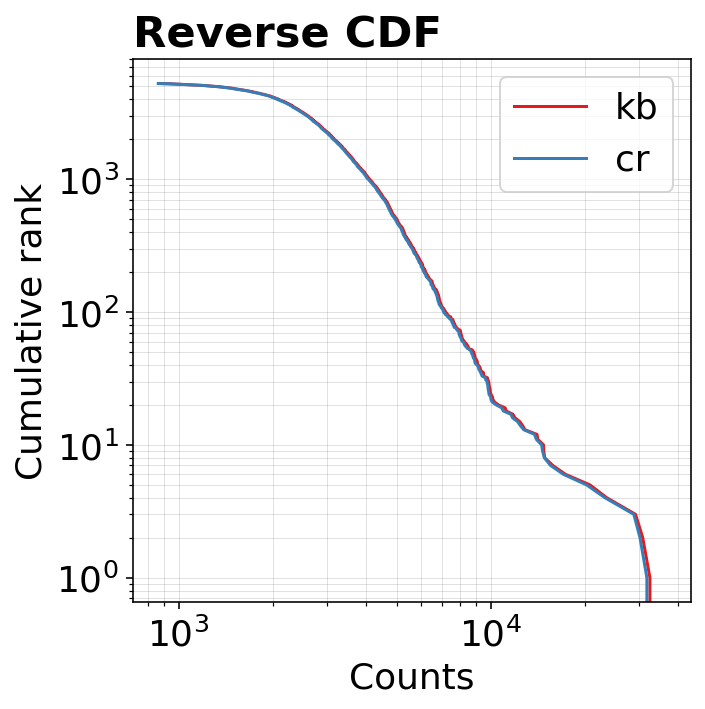

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

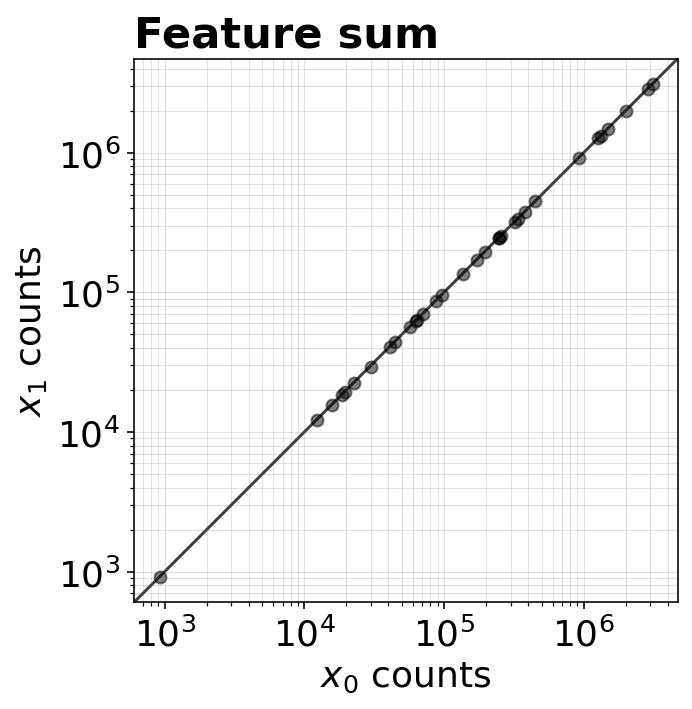

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

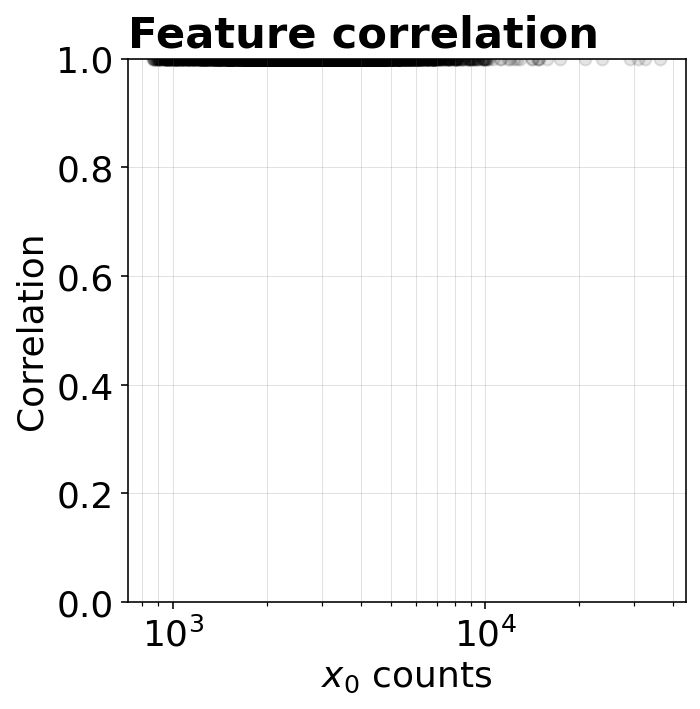

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [20]:
XX_XY = compare.l1_distance(kb.X, cr.X)
YY_YX = compare.l1_distance(cr.X, kb.X)

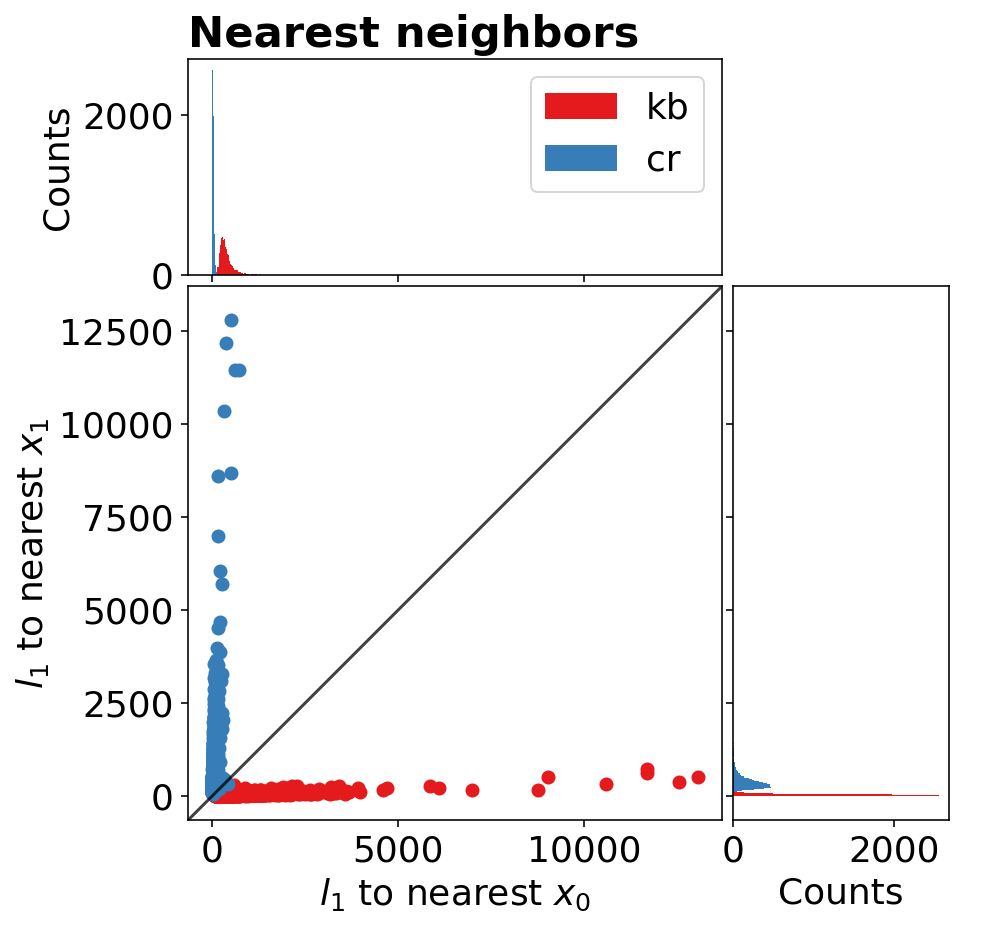

In [21]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [22]:
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

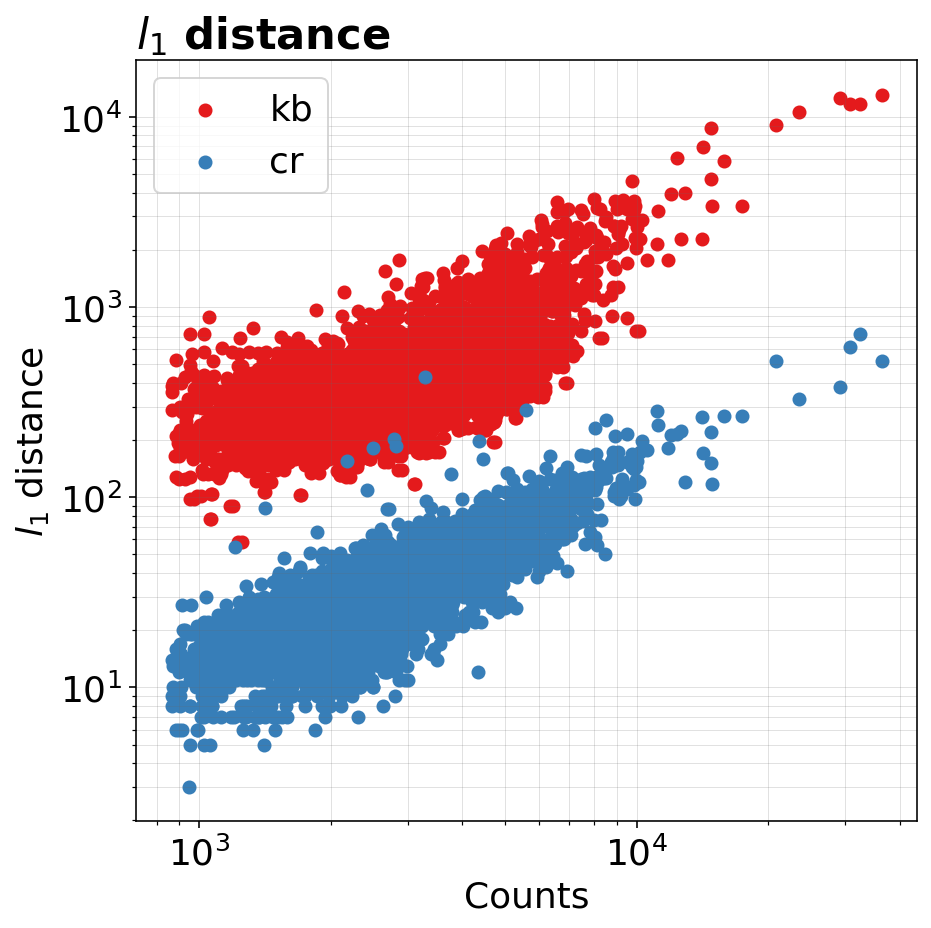

In [23]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)

fig.show()

----------------------------------------

In [31]:
fig.gca()

<Axes:xlabel='Counts'>

In [36]:
colors

{'kb': 'black', 'cr': 'red'}

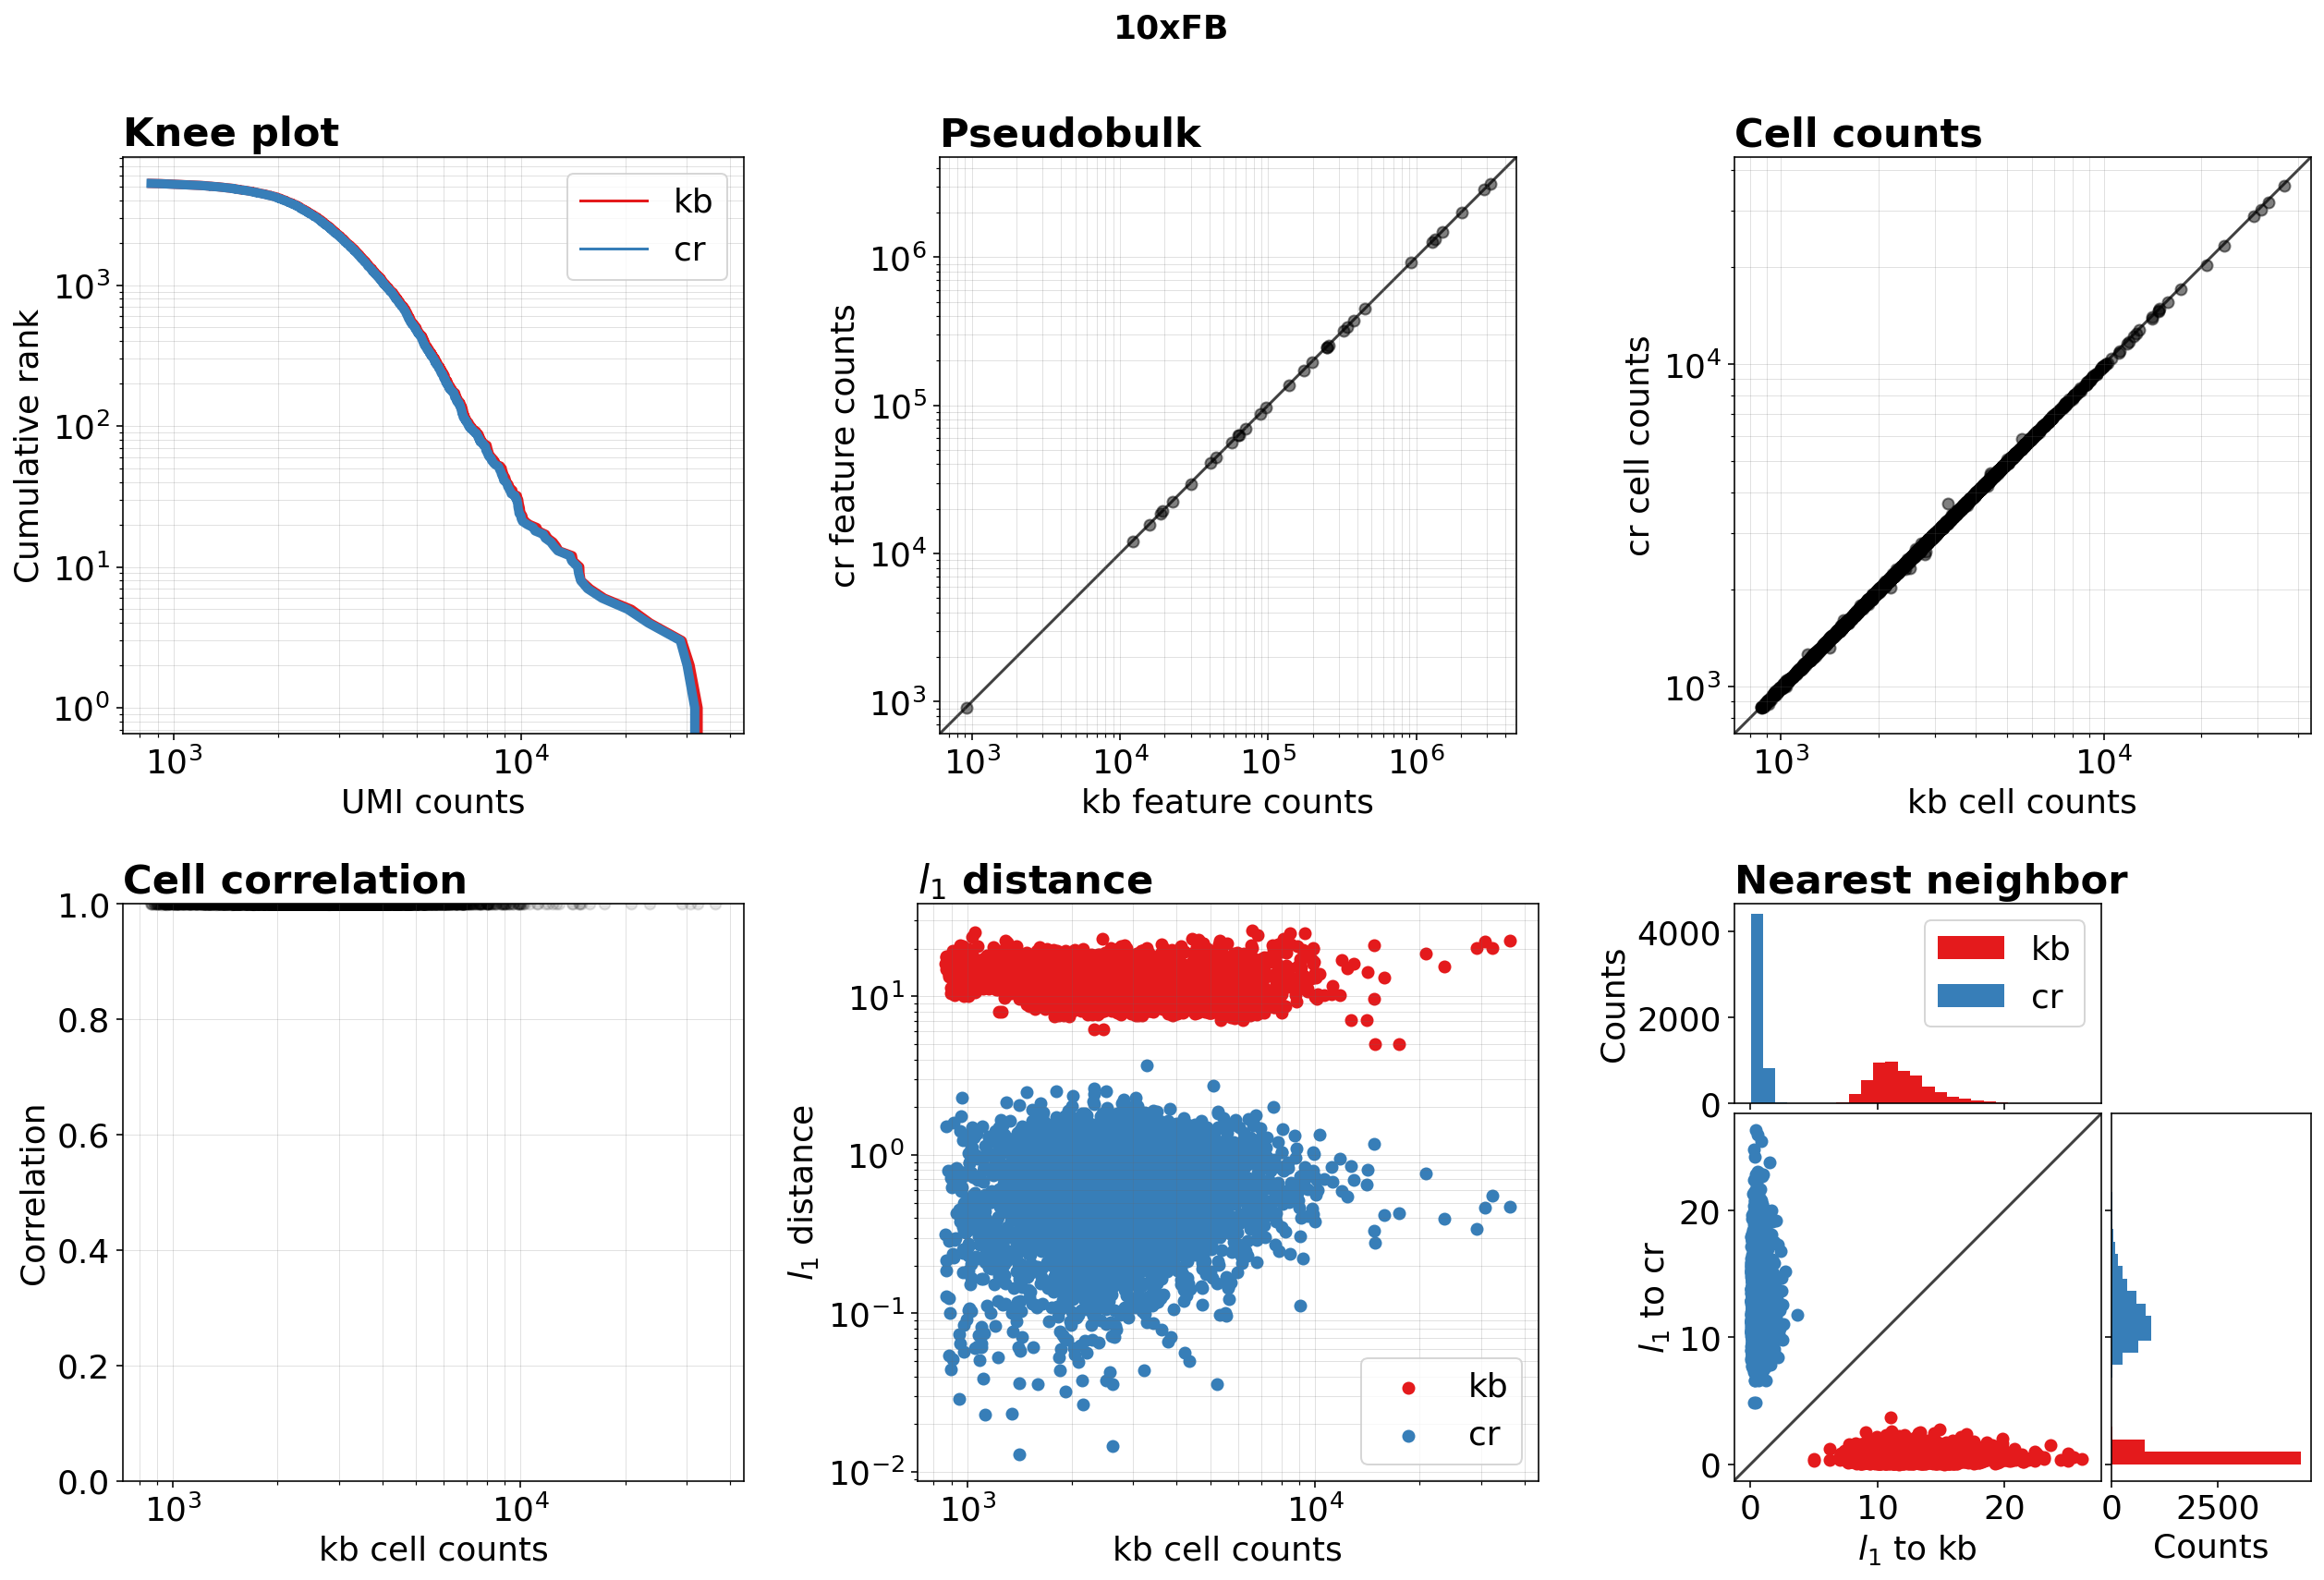

In [45]:

# Putting everything into one figure
row, col = (2, 3)
scale = 6

ds_name = "10xFB"

fig, axs = plt.subplots(figsize=(col*scale, row*scale), nrows=row, ncols=col)
fig.suptitle(ds_name, fontweight='bold', fontsize = fsize, x=0.5, y=0.999)

# knee plot
ax = axs[0,0]

title = "a"
x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors, xlabel="UMI counts", title="Knee plot")

for line in ax.lines:
    line.set_linewidth(5.)


# pseudobulk
ax = axs[0,1]

title = "b"
x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} feature counts", ylabel=f"{labels[1]} feature counts", title="Pseudobulk")
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# cell counts
ax = axs[0,2]

title = "c"
x0, x1 = compare.cmp_sum(kb.X, cr.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} cell counts", ylabel=f"{labels[1]} cell counts", title="Cell counts")


# features correlated
ax = axs[1,0]

title = "d"
x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax, xlabel=f"{labels[0]} cell counts", title="Cell correlation")

# l1 counts
ax = axs[1,1]

title = "e"
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

plot.l1_counts((cnts, XX), (cnts, XY), 
   ax=ax, 
   colors=colors,
   labels=labels,
   xlabel=f"{labels[0]} cell counts")

# nearest neighbor
ax = axs[1,2]

title = "f"
# note, taking log1p here
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cr.X))
YY_YX = compare.l1_distance(np.log1p(cr.X), np.log1p(kb.X))
plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                 ax=ax, 
                 labels=labels, 
                 colors=colors,
                 xlabel=f"$l_1$ to {labels[0]}",
                 ylabel=f"$l_1$ to {labels[1]}",
                 title="Nearest neighbor")

fig.tight_layout()
fig.savefig(f"{ds_name}.png", dpi=300, bbox_inches="tight")
fig.show()